### Import libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim

In [3]:
torch.__version__

'0.4.1'

### Download data:
MNIST is used.

In [4]:
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

In [5]:
mnist_train = datasets.MNIST('./data', train = True, transform=train_transform, download=True)
mnist_test = datasets.MNIST('./data', train = False, transform=test_transform, download=True)

In [6]:
train_size = len(mnist_train)
test_size = len(mnist_test)

In [7]:
trainloader = DataLoader(dataset=mnist_train, batch_size=256, num_workers=4, shuffle=True)
testloader = DataLoader(dataset=mnist_test, batch_size=256, num_workers=4, shuffle=True)

In [8]:
data, label = next(iter(trainloader))
print("Data shape %s and label %s" % (data.shape, label.shape))

Data shape torch.Size([256, 1, 28, 28]) and label torch.Size([256])


In [47]:
data.min()

tensor(0.)

In [9]:
img_shape = [28, 28]

## Support function, plot image:

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

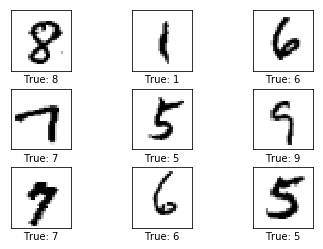

In [11]:
plot_images(images=data[0:9,:, :].numpy(), cls_true=label[0:9])

## Create model:

In [58]:
class Nets(nn.Module):
    def __init__(self, img_shape, hidden_length = 256, sg=False, sg_size = 512):
        super(Nets, self).__init__()
        
        self.sg = sg
        self.sg_size = sg_size
        self.input_length = self.get_input_length(img_shape)
            
        self.hidden_length = hidden_length
        self.fc1 = nn.Linear(self.input_length, self.hidden_length)
        self.bn1 = nn.BatchNorm1d(self.hidden_length)
        if self.sg:
            self.sg1 = nn.Sequential(nn.Linear(self.hidden_length, self.sg_size),
                                    nn.BatchNorm1d(self.sg_size),
                                    nn.ReLU(),
                                    nn.Linear(self.sg_size, self.sg_size),
                                    nn.BatchNorm1d(self.sg_size),
                                    nn.ReLU(),
                                    nn.Linear(self.sg_size, self.hidden_length))
            self.sg2 = nn.Sequential(nn.Linear(self.hidden_length, self.sg_size),
                                    nn.BatchNorm1d(self.sg_size),
                                    nn.ReLU(),
                                    nn.Linear(self.sg_size, self.sg_size),
                                    nn.BatchNorm1d(self.sg_size),
                                    nn.ReLU(),
                                    nn.Linear(self.sg_size, self.hidden_length))
        self.fc2 = nn.Linear(self.hidden_length, self.hidden_length)
        self.bn2 = nn.BatchNorm1d(self.hidden_length)

        self.fc3 = nn.Linear(self.hidden_length, 10)
    
    def forward(self, x):
        sg_tuples = list()
        x = x.view(-1, self.input_length)
        
        # fisrt module
        h1 = F.relu(self.bn1(self.fc1(x)))
        if self.sg:
            h1_clone = torch.tensor(h1.data, requires_grad=True)
            h1_grad = self.sg1(h1_clone)
            sg_tuples.append((h1, h1_grad, h1_clone))
        else:
            h1_clone = h1
        
        # second module
        h2 = F.relu(self.bn2(self.fc2(h1_clone)))
        if self.sg:
            h2_clone = torch.tensor(h2.data, requires_grad=True)
            h2_grad = self.sg2(h2_clone)
            sg_tuples.append((h2, h2_grad, h2_clone))  
        else:
            h2_clone = h2  
        
        # last module
        y = self.fc3(h2_clone)
        
        return sg_tuples, y

    def get_input_length(self, img_shape):
        if isinstance(img_shape, int):
            input_length = img_shape**2
        else:
            input_length = img_shape[0] * img_shape[0]
        return input_length
    
nets = Nets(img_shape)

In [13]:
nets

Nets(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [62]:
criterion = nn.CrossEntropyLoss()
MSE_criterion = nn.MSELoss()

## Training data

In [16]:
# support model:
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            _, outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    total_loss = total_loss / total
    print('Test loss %s Accuracy of the network on the 10000 test images: %.4f %%' % (
        total_loss, 100.0 * correct / total))
    model.train()
    return total_loss, 100.0 * correct / total
test_loss, test_acc = test_model(nets, testloader)

Test loss 2.30299789505 Accuracy of the network on the 10000 test images: 11.0000 %


In [63]:
def trainner(model, optimizer, n_epoch=2):
    res_test = list()
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        total = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            
            # forward
            sg_tuples, outputs = nets(inputs)
            
            # backward the last module.
            loss = criterion(outputs, labels)
            loss.backward()
            
            for h, h_grad, h_clone in sg_tuples[::-1]:
                # backward modules
                h.backward(h_grad)

                # backward Sythetic Grandient module
                loss_sg = MSE_criterion(h_clone.grad, h_grad)
                loss_sg.backward()
            
            # optimize
            optimizer.step()

            # print statistics
            total += labels.size(0)
            running_loss += loss.item() * labels.size(0)

        print('[%d] Train loss: %.4f' %
              (epoch + 1, running_loss / total))
        running_loss = 0.0
        total = 0.0

        test_loss, test_acc = test_model(nets, testloader)
        res_test.append((test_loss, test_acc))
    return res_test
    print('Finished Training')

In [40]:
nets = Nets(img_shape)
nets

Nets(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [29]:
res_baseline = []
for lr in [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]:
    optimizer = optim.Adam(nets.parameters(), lr = lr)
    res_baseline += trainner(nets, optimizer, 4)

[1] Train loss: 0.2664
Test loss 0.179992648411 Accuracy of the network on the 10000 test images: 94.0000 %
[2] Train loss: 0.1262
Test loss 0.119336775231 Accuracy of the network on the 10000 test images: 96.0000 %
[3] Train loss: 0.0984
Test loss 0.124079413056 Accuracy of the network on the 10000 test images: 96.0000 %
[4] Train loss: 0.0886
Test loss 0.107461950302 Accuracy of the network on the 10000 test images: 96.0000 %
[1] Train loss: 0.0468
Test loss 0.0866003954411 Accuracy of the network on the 10000 test images: 97.0000 %
[2] Train loss: 0.0319
Test loss 0.0865964422464 Accuracy of the network on the 10000 test images: 97.0000 %
[3] Train loss: 0.0256
Test loss 0.0815018646717 Accuracy of the network on the 10000 test images: 97.0000 %
[4] Train loss: 0.0229
Test loss 0.0934065309286 Accuracy of the network on the 10000 test images: 97.0000 %
[1] Train loss: 0.0097
Test loss 0.0851707599878 Accuracy of the network on the 10000 test images: 98.0000 %
[2] Train loss: 0.0056


In [59]:
nets = Nets(img_shape, sg=True)
nets

Nets(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sg1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
  )
  (sg2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)


In [60]:
res_sg = []
for lr in [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]:
    optimizer = optim.Adam(nets.parameters(), lr = lr)
    res_sg += trainner(nets, optimizer, 4)

[1] Train loss: 0.9929
Test loss 0.728470699692 Accuracy of the network on the 10000 test images: 75.0000 %
[2] Train loss: 0.7655
Test loss 0.699283234596 Accuracy of the network on the 10000 test images: 76.0000 %
[3] Train loss: 0.7236
Test loss 0.639329090309 Accuracy of the network on the 10000 test images: 79.0000 %
[4] Train loss: 0.6863
Test loss 0.717643393898 Accuracy of the network on the 10000 test images: 79.0000 %
[1] Train loss: 0.7545
Test loss 0.72068272686 Accuracy of the network on the 10000 test images: 76.0000 %
[2] Train loss: 0.8151
Test loss 0.725952873421 Accuracy of the network on the 10000 test images: 75.0000 %
[3] Train loss: 0.8004
Test loss 0.772093284798 Accuracy of the network on the 10000 test images: 74.0000 %
[4] Train loss: 0.7562
Test loss 0.689762483215 Accuracy of the network on the 10000 test images: 77.0000 %
[1] Train loss: 0.7099
Test loss 0.679150976658 Accuracy of the network on the 10000 test images: 78.0000 %
[2] Train loss: 0.7362
Test l

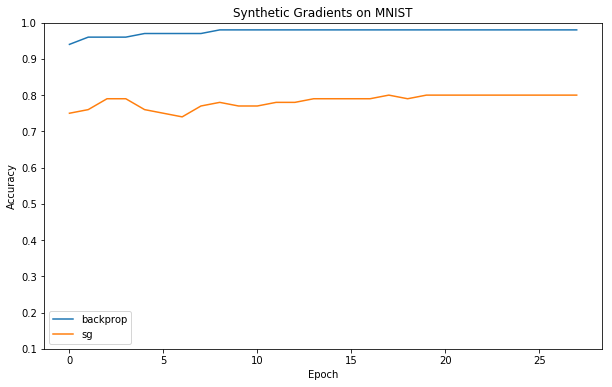

In [61]:
def extract_acc(res):
    return [acc/100.0 for loss, acc in res]
# plot result:
plt.figure(figsize=(10,6))
plt.plot(extract_acc(res_baseline), label="backprop")
plt.plot(extract_acc(res_sg), label="sg")
plt.title("Synthetic Gradients on MNIST")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.1,1.])
plt.legend()

In [69]:
# Training lost in Synthetic gradients is very high 0.6471 compare to nomal model 0.0005.
# Synthetic gradient modules's size will be increase to 1024
nets = Nets(img_shape, sg=True, sg_size=1024)
res_sg = []
for lr in [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]:
    optimizer = optim.Adam(nets.parameters(), lr = lr)
    res_sg += trainner(nets, optimizer, 4)

[1] Train loss: 0.8865
Test loss 0.693650905609 Accuracy of the network on the 10000 test images: 76.0000 %
[2] Train loss: 0.6749
Test loss 0.606348112988 Accuracy of the network on the 10000 test images: 79.0000 %
[3] Train loss: 0.6469
Test loss 0.527630741882 Accuracy of the network on the 10000 test images: 83.0000 %
[4] Train loss: 0.6003
Test loss 0.551804218102 Accuracy of the network on the 10000 test images: 82.0000 %
[1] Train loss: 0.7259
Test loss 0.730057224464 Accuracy of the network on the 10000 test images: 75.0000 %
[2] Train loss: 0.7164
Test loss 0.656775792885 Accuracy of the network on the 10000 test images: 78.0000 %
[3] Train loss: 0.7314
Test loss 0.759483711052 Accuracy of the network on the 10000 test images: 75.0000 %
[4] Train loss: 0.7334
Test loss 0.667026810551 Accuracy of the network on the 10000 test images: 76.0000 %
[1] Train loss: 0.6532
Test loss 0.634019625711 Accuracy of the network on the 10000 test images: 79.0000 %
[2] Train loss: 0.6472
Test 

In [ ]:
# We need to find a more effecient way to train SG model.